In [1]:
from __future__ import absolute_import, division, print_function
import glob
import os
import pdb
import numpy as np
import numpy.random as npr
import tensorflow as tf
import sys
import matplotlib.pyplot as plt
import pdb
import json
import getpass
from scipy import stats
from sklearn import linear_model
from numpy import linalg as LA
import numpy.random as npr
from sklearn.decomposition import PCA
from scipy.spatial import distance
from sklearn.manifold import MDS
from scipy.spatial import distance
from sklearn.cluster import KMeans
import imageio

ui = getpass.getuser()
if ui == 'laura':
    p = '/home/laura'
elif ui == 'lauradriscoll':
    p = '/Users/lauradriscoll/Documents'
elif ui == 'lndrisco':
    p = '/home/users/lndrisco'

net = 'continuous_tasks'
PATH_NET = os.path.join(p,'code/multitask-nets',net)
sys.path.insert(0, PATH_NET)
from task import generate_trials, rule_name, rule_index_map, rules_dict
from network import Model, FixedPoint_Model
import tools
from tools_lnd import generate_Beta_epoch, get_T_inds, add_ax_labels, TDR_axes, eigenspectrum_axes, out_axes
from tools_lnd import make_h_trial_rule, comp_eig_decomp, plot_FP, get_model_params, take_names, name_best_ckpt
from tools_lnd import plot_epoch_dynamics, make_fp_struct, make_fp_tdr_fig, make_h_trial_rule, get_D, find_ckpts

In [106]:
rule = 'contin_delaydm12'
dir_specific_all = 'crystals/softplus/int20_mod12diff'#vary_inputs_w_alpha
m = os.path.join(p,'code/multitask-nets/continuous_tasks/data',dir_specific_all,str(1))
ckpt_n = name_best_ckpt(m,rule)
ckpt_n_dir = os.path.join(m,'ckpts/model.ckpt-' + str(int(ckpt_n)))
    
model = Model(m)
with tf.Session() as sess:

    model.saver.restore(sess,ckpt_n_dir)
    # get all connection weights and biases as tensorflow variables
    var_list = model.var_list
    # evaluate the parameters after training
    params = [sess.run(var) for var in var_list]
    # get hparams
    hparams = model.hp
    trial_master = generate_trials(rule, hparams, mode = 'random', batch_size = 100, 
                                   noise_on=True, delay_fac =1,alpha_mod1 = .2)   

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/code/multitask-nets/continuous_tasks/data/crystals/softplus/int20_mod12diff/1/ckpts/model.ckpt-133000


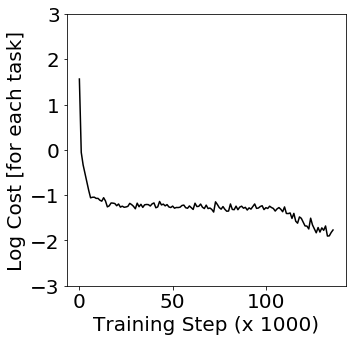

In [107]:
fname = os.path.join(m, 'log.json')

fig = plt.figure(figsize=(5, 5))
cmap=plt.get_cmap('Greys')
with open(fname, 'r') as f:
    log_all = json.load(f)
for r in [rule,]:
    c = 'k'
    ax = fig.add_subplot(1,1,1)
    x = np.log(log_all['cost_'+rule])
    plt.plot(x,'-',c = c)
    ax.set_xlabel('Training Step (x 1000)')
    ax.set_ylabel('Log Cost [for each task]')
    plt.ylim([-3,3])
plt.show() 

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/code/multitask-nets/continuous_tasks/data/crystals/softplus/int20_mod12diff/1/ckpts/model.ckpt-133000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/code/multitask-nets/continuous_tasks/data/crystals/softplus/int20_mod12diff/1/ckpts/model.ckpt-133000
Variables being optimized:
<tf.Variabl

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/code/multitask-nets/continuous_tasks/data/crystals/softplus/int20_mod12diff/1/ckpts/model.ckpt-133000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/code/multitask-nets/continuous_tasks/data/crystals/softplus/int20_mod12diff/1/ckpts/model.ckpt-133000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters f

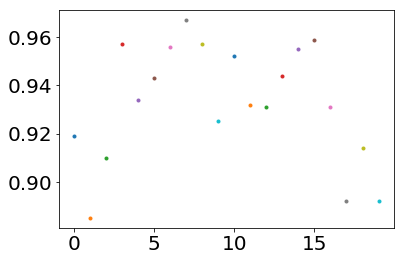

In [108]:
from tools_lnd import get_perf

for alpha_mod1 in range(20):

    model = Model(m)
    with tf.Session() as sess:
        model.saver.restore(sess,ckpt_n_dir)
        model._sigma=0
        var_list = model.var_list
        hparams = model.hp
        trial = generate_trials(rule, hparams, mode='random', noise_on=False, \
                                batch_size =1000, delay_fac =1, alpha_mod1 = alpha_mod1)
        feed_dict = tools.gen_feed_dict(model, trial, hparams)
        h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) 

    x = get_perf(y_hat_tf, trial.y_loc)

#     loc_temp = np.arctan2(y_hat_tf[-1,:,1], y_hat_tf[-1,:,2])
#     loc = np.mod(loc_temp, 2*np.pi) # check this? January 22 2019

#     coh_mod1 = trial.stim_strength[:,0]-trial.stim_strength[:,1]
#     coh_mod2 = trial.stim_strength[:,2]-trial.stim_strength[:,3]

#     s1 = alpha_mod1
#     s2 = 1-s1
#     stim1_strengths = s1*trial.stim_strength[:,0] + s2*trial.stim_strength[:,2]
#     stim2_strengths = s1*trial.stim_strength[:,1] + s2*trial.stim_strength[:,3]

#     stim1_locs = trial.stim_locs[:,0]
#     stim2_locs = trial.stim_locs[:,1]
#     stim_locs = [stim1_locs[i] if (stim1_strengths[i]>stim2_strengths[i])
#                     else stim2_locs[i] for i in range(len(stim1_locs))]

#     y_loc1 = trial.stim_locs[:,0]
#     y_loc1[coh_mod1<0] = trial.stim_locs[coh_mod1<0,1]

#     y_loc2 = trial.stim_locs[:,2]
#     y_loc2[coh_mod2<0] = trial.stim_locs[coh_mod2<0,3]

#     # plt.subplot(1,4,1)
#     # plt.plot(trial.y_loc[-1,:],y_loc1,'.')

#     # plt.subplot(1,4,2)
#     # plt.plot(trial.y_loc[-1,:],y_loc2,'.')

#     # plt.subplot(1,4,3)
#     # plt.hist(trial.y_loc[-1,:]-stim_locs)

    # plt.subplot(1,4,4)
    plt.plot(alpha_mod1,np.mean(x),'.',label = str(alpha_mod1))
    
# plt.legend()
plt.show()

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/code/multitask-nets/continuous_tasks/data/crystals/softplus/int/2/ckpts/model.ckpt-137000


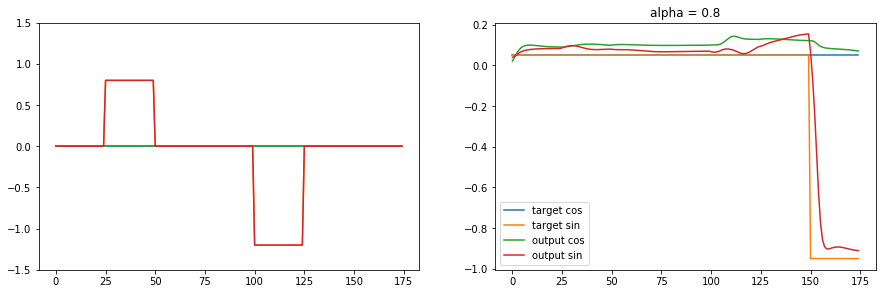

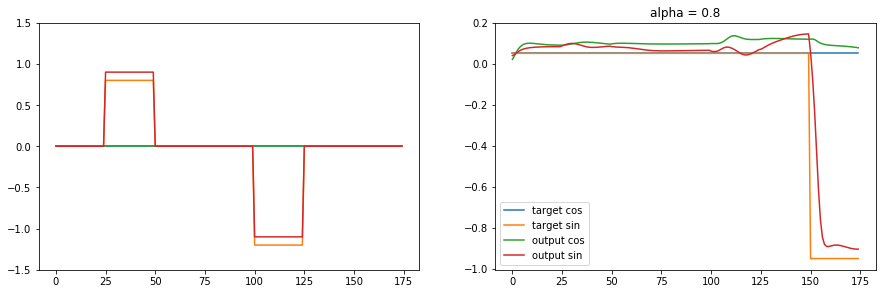

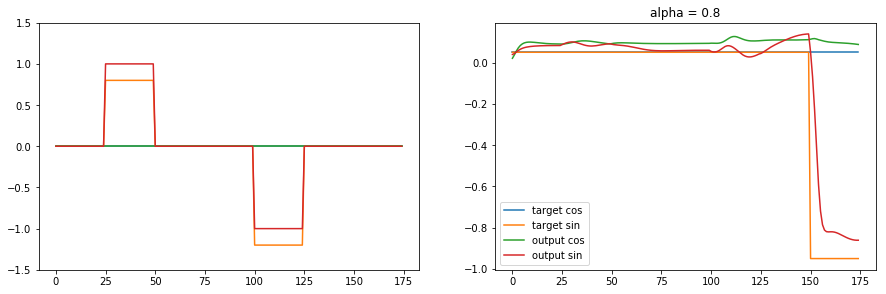

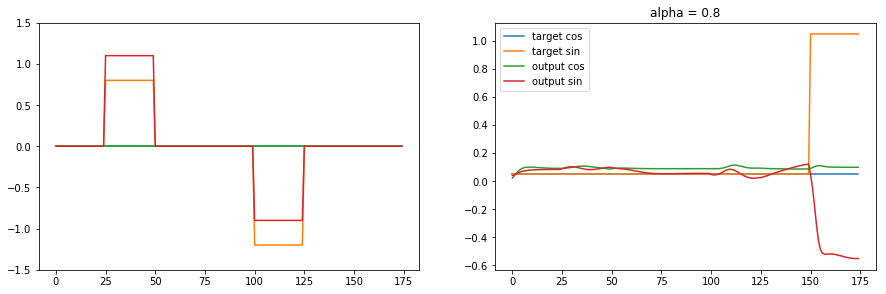

KeyboardInterrupt: 

In [18]:
#These plots show some targets and outputs, again to show that the network looks sufficiently trained

for alpha_mod1 in [.8,1]:#np.linspace(0,1,5):
    model = Model(m)
    with tf.Session() as sess:
        model.saver.restore(sess,ckpt_n_dir)
        model._sigma=0
        var_list = model.var_list
        hparams = model.hp
        trial = generate_trials(rule, hparams, mode='test', noise_on=False, \
                                batch_size =100, delay_fac =1, alpha_mod1 = alpha_mod1)
        feed_dict = tools.gen_feed_dict(model, trial, hparams)
        h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) 

    for y in range(40): # look at outputs compared to targets on 4 trials
        fig = plt.figure(figsize=(15, 10))
        
        ax = fig.add_subplot(2,2,1)
        plt.plot(trial.x[:,y,1])
        plt.plot(trial.x[:,y,2])
        plt.ylim([-1.5,1.5])

        ax = fig.add_subplot(2,2,1)
        plt.plot(trial.x[:,y,3])
        plt.plot(trial.x[:,y,4])
        plt.ylim([-1.5,1.5])
            
        ax = fig.add_subplot(2,2,2)
        plt.plot(trial.y[:,y,1],label = 'target cos')
        plt.plot(trial.y[:,y,2],label = 'target sin')
        plt.plot(y_hat_tf[:,y,1],label = 'output cos')
        plt.plot(y_hat_tf[:,y,2],label = 'output sin')

        plt.legend()
        plt.title('alpha = ' +str(alpha_mod1))
        plt.show()

In [124]:
h_tf_all = []
in_all = []
for alpha_mod1 in range(20):
    model = Model(m)
    with tf.Session() as sess:
        model.saver.restore(sess,ckpt_n_dir)
        model._sigma=0
        var_list = model.var_list
        hparams = model.hp
        trial = generate_trials(rule, hparams, mode='random', noise_on=True, \
                                batch_size =3000, delay_fac =1, alpha_mod1 = alpha_mod1)
        
#         plt.plot(trial.x[0,int(alpha_mod1*19),5:],label = str(int(alpha_mod1*19)))

        feed_dict = tools.gen_feed_dict(model, trial, hparams)
        h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) 
        
        if alpha_mod1==0:
            h_tf_all = h_tf[trial.epochs['fix1'][1]-1,:,:]
            in_all = trial.x[0,:,:]
        else:
            h_tf_all = np.concatenate((h_tf_all, h_tf[trial.epochs['fix1'][1]-1,:,:]),axis = 0)
            in_all = np.concatenate((in_all, trial.x[0,:,:]), axis = 0)
            
# plt.legend()            
# plt.show()

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/code/multitask-nets/continuous_tasks/data/crystals/softplus/int20_mod12diff/1/ckpts/model.ckpt-133000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/code/multitask-nets/continuous_tasks/data/crystals/softplus/int20_mod12diff/1/ckpts/model.ckpt-133000
Variables being optimized:
<tf.Variabl

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/code/multitask-nets/continuous_tasks/data/crystals/softplus/int20_mod12diff/1/ckpts/model.ckpt-133000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/code/multitask-nets/continuous_tasks/data/crystals/softplus/int20_mod12diff/1/ckpts/model.ckpt-133000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters f

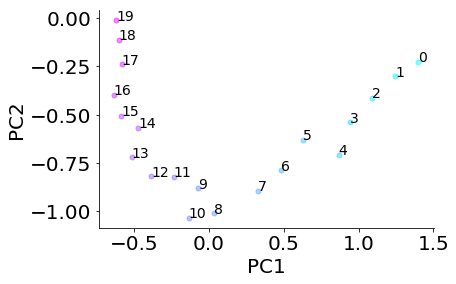

In [125]:
X =  h_tf_all#in_all #

pca = PCA(n_components = 2)
_ = pca.fit_transform(X)
D_use = pca.components_.T

n_trials = np.shape(h_tf)[1]
n_tasks = int(np.shape(h_tf_all)[0]/n_trials)
cmap = plt.get_cmap('cool')
ax = plt.subplot(111)
for t in range(n_tasks):
    trial_set = range(t*n_trials,(t+1)*n_trials)
    h_temp = X[trial_set,:]
    h_D = np.dot(h_temp,D_use)
    plt.plot(np.mean(h_D[:,0]),np.mean(h_D[:,1]),'.',c = cmap(t/n_tasks),alpha = .5,markersize = 10)
    plt.text(np.mean(h_D[:,0]),np.mean(h_D[:,1]),str(t),fontsize = 14)
    
# plt.xlim([0,3])
# plt.ylim([-.15,.75])

plt.xlabel('PC1')
plt.ylabel('PC2')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

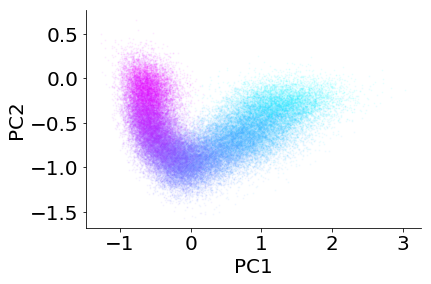

In [126]:
n_trials = np.shape(h_tf)[1]
n_tasks = int(np.shape(h_tf_all)[0]/n_trials)
ax = plt.subplot(111)
for t in range(n_tasks):
    trial_set = range(t*n_trials,(t+1)*n_trials)
    h_temp = X[trial_set,:]
    h_D = np.dot(h_temp,D_use)
    plt.plot(h_D[:,0],h_D[:,1],'.',c = cmap(t/n_tasks),alpha = .05,markersize = 2)
#     plt.plot(h_D[:,0],np.ones(len(h_D[:,0])),'.',c = cmap(t/n_tasks),alpha = .05,markersize = 2)

# plt.xlim([-1.5,5])
# plt.ylim([-1.5,2.5])
    
plt.xlabel('PC1')
plt.ylabel('PC2')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [127]:
[0,5,10,15,19]

[0, 5, 10, 15, 19]

In [128]:
def image_train(m,D_use,fig_title):
    
    cmap = plt.get_cmap('cool')
    n_tasks = 5
    
    fldr = os.path.join(m,'training_gif/')
    if not os.path.exists(fldr):
        os.makedirs(fldr)

    movie_dir = os.path.join(fldr,fig_title)
    if not os.path.exists(movie_dir):
        os.makedirs(movie_dir)
    
    s_all = find_ckpts(m)
    
    im_num = 0
    for ckpt_n in np.sort(s_all)[0:-1:4]: 
        fig = plt.figure(figsize=(10, 5))
        im_num+=1
    
        ckpt_n_dir = os.path.join(m,'ckpts/model.ckpt-' + str(int(ckpt_n)))

        ax2 = plt.subplot(1,2,2)
        for alpha_mod1 in [0,5,10,15,19]:    
            model = Model(m)
            with tf.Session() as sess:

                model.saver.restore(sess,ckpt_n_dir)
                model._sigma=0
                var_list = model.var_list
                hparams = model.hp
                trial = generate_trials(rule, hparams, mode='random', noise_on=True, \
                                        batch_size =3000, delay_fac =1, alpha_mod1 = alpha_mod1)

                feed_dict = tools.gen_feed_dict(model, trial, hparams)
                h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) 

                h_temp = h_tf[trial.epochs['fix1'][1]-1,:,:]
                h_D = np.dot(h_temp,D_use)
                plt.plot(h_D[:,0],h_D[:,1],'.',c = cmap(alpha_mod1/19),alpha = .05,markersize = 2)
                
        plt.xlim([-1.5,5])
        plt.ylim([-1.5,2.5])
          
        ax = plt.subplot(1,2,1)
        fname = os.path.join(m, 'log.json')
        with open(fname, 'r') as f:
            log_all = json.load(f)
        for r in [rule,]:
            c = 'k'
            x = np.log(log_all['cost_'+rule])
            plt.plot(x[:int(ckpt_n/1000)],'-',c = c)
            ax.set_xlabel('Training Step (x 1000)')
            ax.set_ylabel('Log Cost [for each task]')
            plt.ylim([-3,3])
            plt.xlim([0,210])

        plt.savefig(movie_dir +'/'+ str(im_num) + '.png')
        plt.show()
    return im_num, movie_dir

In [129]:
def animate_training(m,D_use,fig_title):
    
    im_num, movie_dir = image_train(m,D_use,fig_title)

    images = []
    for t in range(1,im_num):#T*xt):
        filename = movie_dir +'/'+ str(t) + '.png'
        images.append(imageio.imread(filename))
    imageio.mimsave(movie_dir+'/movie.gif', images)

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/code/multitask-nets/continuous_tasks/data/crystals/softplus/int20/0/ckpts/model.ckpt-1
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/code/multitask-nets/continuous_tasks/data/crystals/softplus/int20/0/ckpts/model.ckpt-1
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0

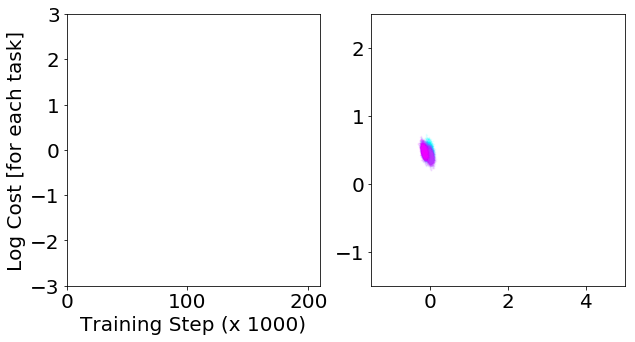

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/code/multitask-nets/continuous_tasks/data/crystals/softplus/int20/0/ckpts/model.ckpt-5
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/code/multitask-nets/continuous_tasks/data/crystals/softplus/int20/0/ckpts/model.ckpt-5
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0

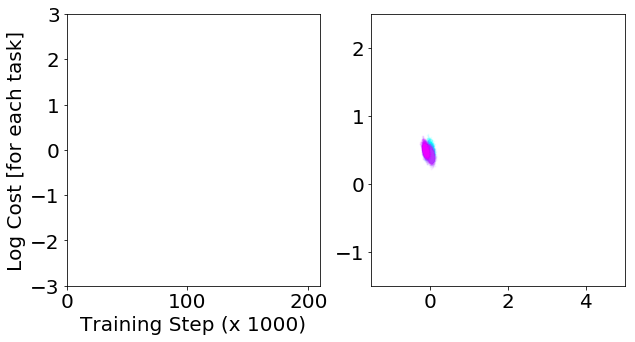

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/code/multitask-nets/continuous_tasks/data/crystals/softplus/int20/0/ckpts/model.ckpt-9
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/code/multitask-nets/continuous_tasks/data/crystals/softplus/int20/0/ckpts/model.ckpt-9
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0

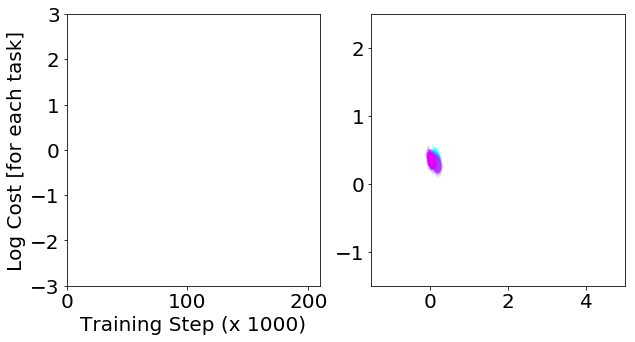

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/code/multitask-nets/continuous_tasks/data/crystals/softplus/int20/0/ckpts/model.ckpt-4000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/code/multitask-nets/continuous_tasks/data/crystals/softplus/int20/0/ckpts/model.ckpt-4000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/ke

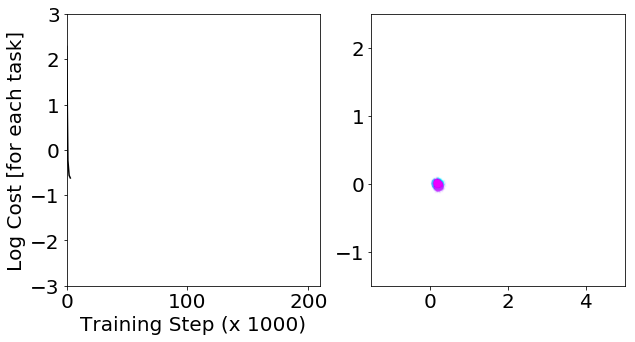

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/code/multitask-nets/continuous_tasks/data/crystals/softplus/int20/0/ckpts/model.ckpt-8000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/code/multitask-nets/continuous_tasks/data/crystals/softplus/int20/0/ckpts/model.ckpt-8000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/ke

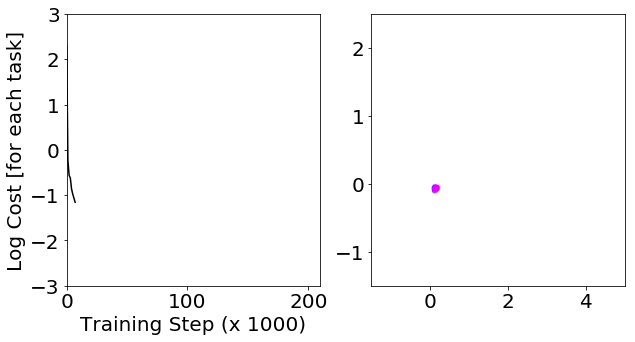

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/code/multitask-nets/continuous_tasks/data/crystals/softplus/int20/0/ckpts/model.ckpt-12000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/code/multitask-nets/continuous_tasks/data/crystals/softplus/int20/0/ckpts/model.ckpt-12000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/

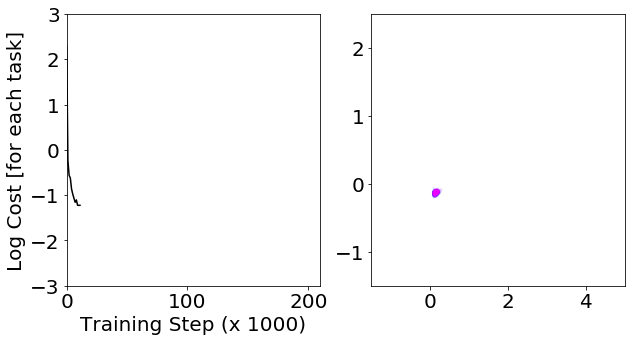

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/code/multitask-nets/continuous_tasks/data/crystals/softplus/int20/0/ckpts/model.ckpt-16000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/code/multitask-nets/continuous_tasks/data/crystals/softplus/int20/0/ckpts/model.ckpt-16000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/

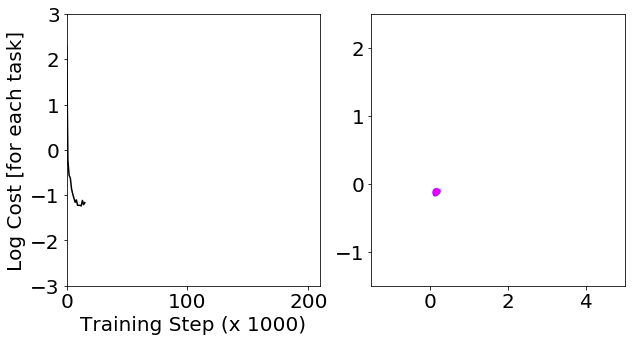

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/code/multitask-nets/continuous_tasks/data/crystals/softplus/int20/0/ckpts/model.ckpt-20000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/code/multitask-nets/continuous_tasks/data/crystals/softplus/int20/0/ckpts/model.ckpt-20000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/

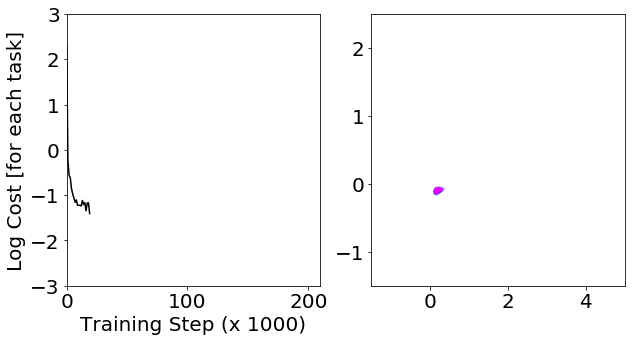

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/code/multitask-nets/continuous_tasks/data/crystals/softplus/int20/0/ckpts/model.ckpt-24000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/code/multitask-nets/continuous_tasks/data/crystals/softplus/int20/0/ckpts/model.ckpt-24000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/

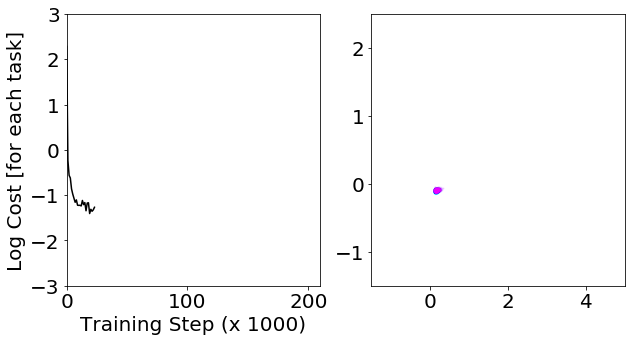

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/code/multitask-nets/continuous_tasks/data/crystals/softplus/int20/0/ckpts/model.ckpt-28000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/code/multitask-nets/continuous_tasks/data/crystals/softplus/int20/0/ckpts/model.ckpt-28000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/

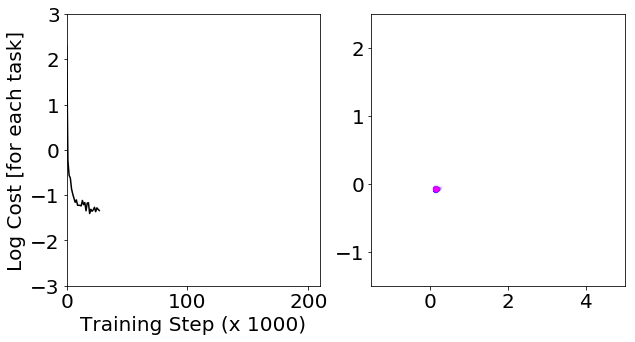

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/code/multitask-nets/continuous_tasks/data/crystals/softplus/int20/0/ckpts/model.ckpt-32000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/code/multitask-nets/continuous_tasks/data/crystals/softplus/int20/0/ckpts/model.ckpt-32000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/

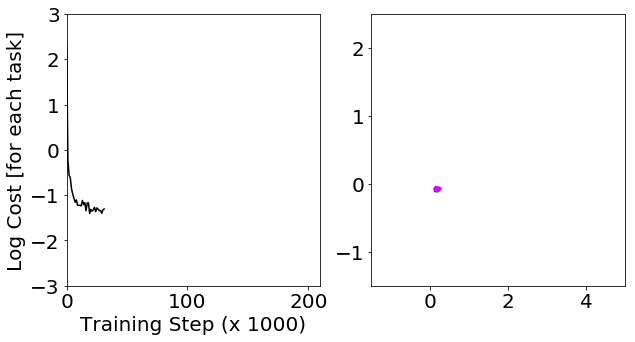

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/code/multitask-nets/continuous_tasks/data/crystals/softplus/int20/0/ckpts/model.ckpt-36000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/code/multitask-nets/continuous_tasks/data/crystals/softplus/int20/0/ckpts/model.ckpt-36000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/

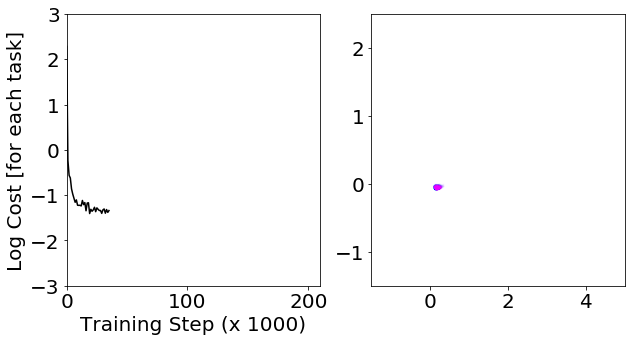

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/code/multitask-nets/continuous_tasks/data/crystals/softplus/int20/0/ckpts/model.ckpt-40000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/code/multitask-nets/continuous_tasks/data/crystals/softplus/int20/0/ckpts/model.ckpt-40000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/

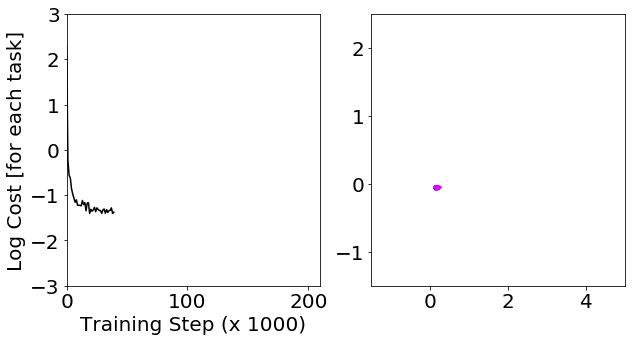

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/code/multitask-nets/continuous_tasks/data/crystals/softplus/int20/0/ckpts/model.ckpt-44000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/code/multitask-nets/continuous_tasks/data/crystals/softplus/int20/0/ckpts/model.ckpt-44000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/

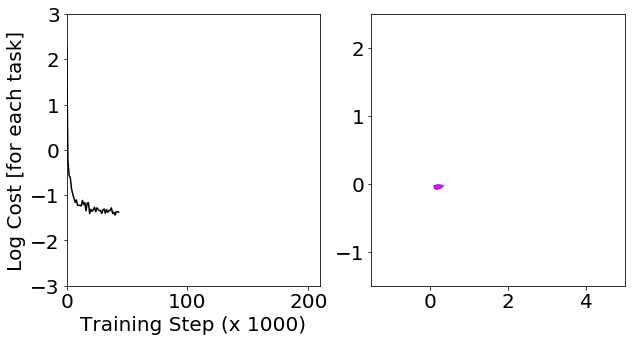

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/code/multitask-nets/continuous_tasks/data/crystals/softplus/int20/0/ckpts/model.ckpt-48000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/code/multitask-nets/continuous_tasks/data/crystals/softplus/int20/0/ckpts/model.ckpt-48000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/

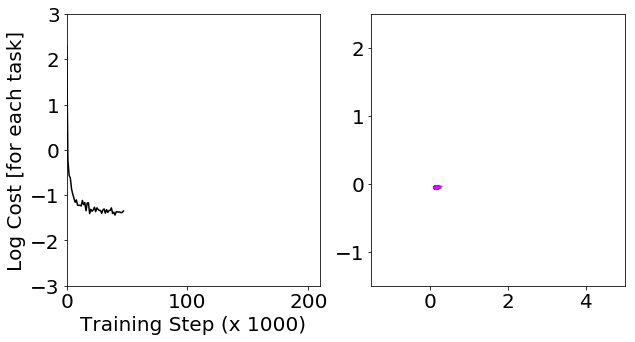

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/code/multitask-nets/continuous_tasks/data/crystals/softplus/int20/0/ckpts/model.ckpt-52000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/code/multitask-nets/continuous_tasks/data/crystals/softplus/int20/0/ckpts/model.ckpt-52000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/

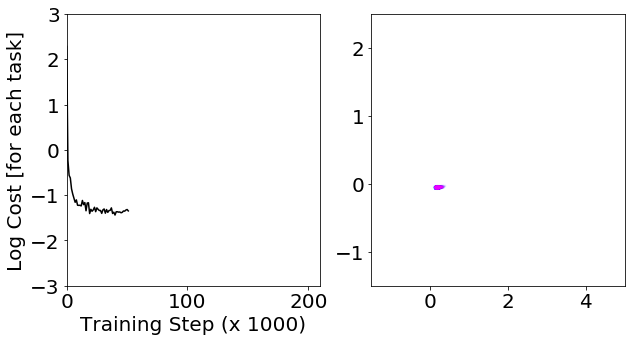

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/code/multitask-nets/continuous_tasks/data/crystals/softplus/int20/0/ckpts/model.ckpt-56000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/code/multitask-nets/continuous_tasks/data/crystals/softplus/int20/0/ckpts/model.ckpt-56000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/

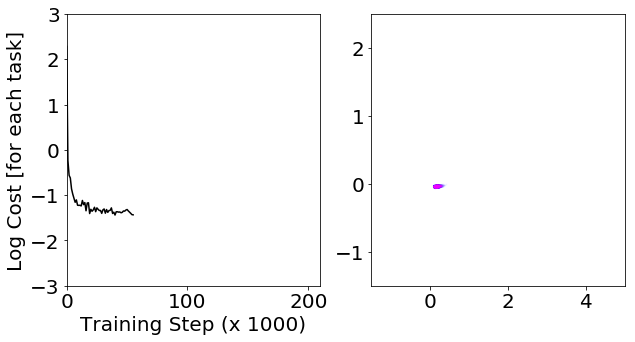

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/code/multitask-nets/continuous_tasks/data/crystals/softplus/int20/0/ckpts/model.ckpt-60000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/code/multitask-nets/continuous_tasks/data/crystals/softplus/int20/0/ckpts/model.ckpt-60000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/

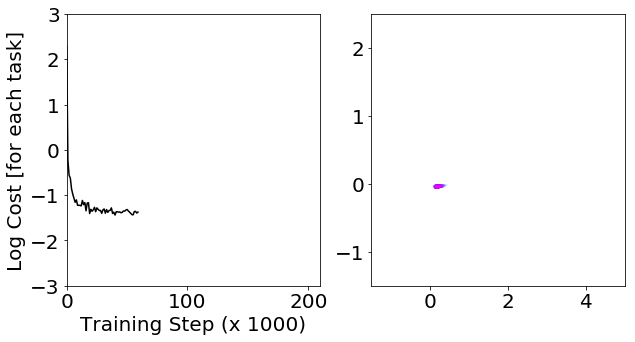

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/code/multitask-nets/continuous_tasks/data/crystals/softplus/int20/0/ckpts/model.ckpt-64000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/code/multitask-nets/continuous_tasks/data/crystals/softplus/int20/0/ckpts/model.ckpt-64000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/

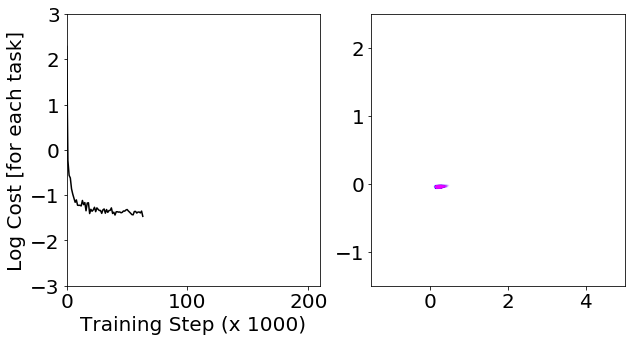

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/code/multitask-nets/continuous_tasks/data/crystals/softplus/int20/0/ckpts/model.ckpt-68000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/code/multitask-nets/continuous_tasks/data/crystals/softplus/int20/0/ckpts/model.ckpt-68000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/

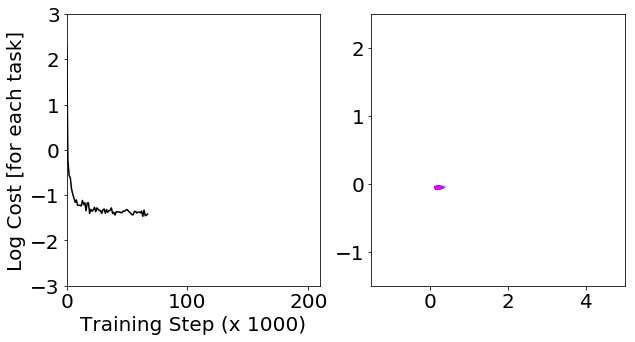

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/code/multitask-nets/continuous_tasks/data/crystals/softplus/int20/0/ckpts/model.ckpt-72000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/code/multitask-nets/continuous_tasks/data/crystals/softplus/int20/0/ckpts/model.ckpt-72000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/

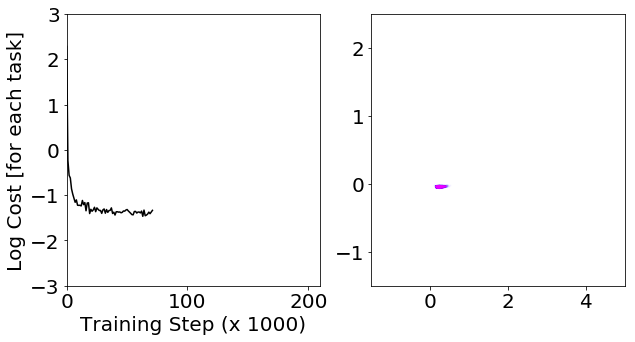

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>


In [ ]:
rule = 'contin_delaydm12'
# dir_specific_all = 'crystals/softplus/one_hot_rule'#vary_inputs_w_alpha
# m = os.path.join(p,'data/rnn/multitask/contin',dir_specific_all,str(0))
dir_specific_all = 'crystals/softplus/int20'#vary_inputs_w_alpha
m = os.path.join(p,'code/multitask-nets/continuous_tasks/data',dir_specific_all,str(0))
fig_title = 'Context_IC'
animate_training(m,D_use,fig_title)

In [ ]:
images = []
for t in range(25,54):#T*xt):
    filename = movie_dir +'/'+ str(t) + '.png'
    images.append(imageio.imread(filename))
imageio.mimsave(movie_dir+'/movie.gif', images)

In [ ]:
# epoch = 'stim1'
# h_tf_all = []
# alpha_mod1_list = [.5,]
# for alpha_mod1 in alpha_mod1_list:
#     model = Model(m)
#     with tf.Session() as sess:
#         model.saver.restore(sess,ckpt_n_dir)
#         model._sigma=0
#         var_list = model.var_list
#         hparams = model.hp
#         trial = generate_trials(rule, hparams, mode='random', noise_on=True, \
#                                 batch_size =3000, delay_fac =1, alpha_mod1 = alpha_mod1)
#         feed_dict = tools.gen_feed_dict(model, trial, hparams)
#         h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) 
        
#         if alpha_mod1==alpha_mod1_list[0]:
#             h_tf_all = h_tf[trial.epochs[epoch][1]-1,:,:]
#         else:
#             h_tf_all = np.concatenate((h_tf_all, h_tf[trial.epochs[epoch][1]-1,:,:]),axis = 0)

In [114]:
from tools_lnd import generate_Beta_epoch, same_stim_trial, gen_trials_from_model_dir
epoch = 'stim1'
trial_master1 = gen_trials_from_model_dir(m,'delaydm1',noise_on = False)
trial_master2 = gen_trials_from_model_dir(m,'delaydm2',noise_on = False)

model = Model(m)
with tf.Session() as sess:
    model.saver.restore(sess,ckpt_n_dir)
    model._sigma=0
    var_list = model.var_list
    hparams = model.hp
    
    alpha_mod1 = 19
    trial1 = same_stim_trial(trial_master1,alpha_mod1)
    feed_dict = tools.gen_feed_dict(model, trial1, hparams)
    h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) 
    Beta1 = generate_Beta_epoch(h_tf,trial1,ind = -1,mod = 1)
    
    alpha_mod1 = 0
    trial2 = same_stim_trial(trial_master2,alpha_mod1)
    feed_dict = tools.gen_feed_dict(model, trial2, hparams)
    h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) 
    Beta2 = generate_Beta_epoch(h_tf,trial2,ind = -1,mod = 2)

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/code/multitask-nets/continuous_tasks/data/crystals/softplus/int20_mod12diff/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/code/multitask-nets/continuous_tasks/data/crystals/softplus/int20_mod12diff/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/code/mu

In [121]:
D = Beta1['stim1']

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/code/multitask-nets/continuous_tasks/data/crystals/softplus/int20_mod12diff/1/ckpts/model.ckpt-133000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/code/multitask-nets/continuous_tasks/data/crystals/softplus/int20_mod12diff/1/ckpts/model.ckpt-133000
Variables being optimized:
<tf.Variabl

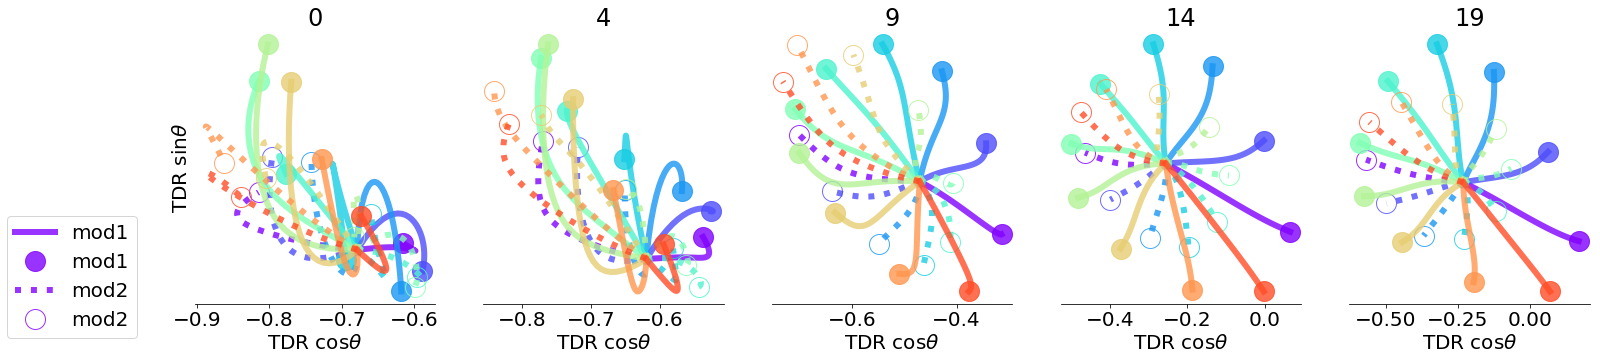

In [122]:
from tools_lnd import gen_trials_from_model_dir,same_stim_trial,gen_X_from_model_dir
model_dir_all = m

trial_inds = range(trial_master1.epochs[epoch][0]-1,trial_master1.epochs[epoch][1])
ms = 20
lw = 6
task_n = 5

cmap = plt.get_cmap('rainbow')
fig = plt.figure(figsize=(5*task_n, 5))
plt.rcParams.update({'font.size': 20})
task_i = 0
for s1 in np.linspace(0,1,task_n):
    task_i += 1
    
    task_num = int(s1*19)
    trial1 = same_stim_trial(trial_master1,task_num)
    X1,x1 = gen_X_from_model_dir(m,trial1,d = ckpt_n_dir)
    
    trial2 = same_stim_trial(trial_master2,task_num)
    X2,x2 = gen_X_from_model_dir(m,trial2,d = ckpt_n_dir)

    ax = plt.subplot(1,task_n,task_i)
    for t in range(0,np.shape(x2)[1],int(np.shape(x2)[1]/10)):
        xi1 = np.dot(x1[:,t,:].T,D)
        xi2 = np.dot(x2[:,t,:].T,D)
        if t==0:
            plt.plot(xi1[trial_inds,0],xi1[trial_inds,1],c = cmap(t/np.shape(x2)[1]),label = 'mod1',alpha = .8,linewidth = lw)
            plt.plot(xi1[trial_inds[-1],0],xi1[trial_inds[-1],1],'o',c = cmap(t/np.shape(x2)[1]),
                     markersize = ms,alpha = .8,label = 'mod1')
            
            plt.plot(xi2[trial_inds,0],xi2[trial_inds,1],':',c = cmap(t/np.shape(x2)[1]),
                     linewidth = lw,label = 'mod2',alpha = .8)
            plt.plot(xi2[trial_inds[-1],0],xi2[trial_inds[-1],1],'o',c = cmap(t/np.shape(x2)[1]),
                     linewidth = lw,markerfacecolor = 'none',markersize = ms,alpha = .8,label = 'mod2')
        else:
            plt.plot(xi1[trial_inds,0],xi1[trial_inds,1],c = cmap(t/np.shape(x2)[1]),alpha = .8,linewidth = lw)
            plt.plot(xi1[trial_inds[-1],0],xi1[trial_inds[-1],1],'o',c = cmap(t/np.shape(x2)[1]),
                     linewidth = lw,markersize = ms,alpha = .8)
            
            plt.plot(xi2[trial_inds,0],xi2[trial_inds,1],':',c = cmap(t/np.shape(x2)[1]),linewidth = lw,alpha = .8)
            plt.plot(xi2[trial_inds[-1],0],xi2[trial_inds[-1],1],'o',c = cmap(t/np.shape(x2)[1]),
                     linewidth = lw,markerfacecolor = 'none',markersize = ms,alpha = .8)
#     plt.ylim((-1,2))    
#     plt.xlim((-.3,.25))    
    plt.title(str(task_num))
    plt.xlabel(r'TDR cos$\theta$')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    if task_i > 0:
        ax.spines['left'].set_visible(False)
        plt.yticks([])
plt.subplot(1,task_n,1)
plt.ylabel(r'TDR sin$\theta$')
plt.legend(loc='center right', bbox_to_anchor=[-.2,.1])
fldr = os.path.join(m,'compare_effective_inputs_DelayDM/')
if not os.path.exists(fldr):
    os.makedirs(fldr)
plt.savefig(fldr+'visXstimCond.pdf')
plt.savefig(fldr+'visXstimCond.png')
plt.show()

In [117]:
from tools_lnd import make_Jac_u_dot_delu

# trial_master1 = gen_trials_from_model_dir(m,'delaydm1',noise_on = False)
# trial_master2 = gen_trials_from_model_dir(m,'delaydm2',noise_on = False)
n_trials = np.shape(trial_master1.x)[1]
trial_set = range(0,n_trials,int(n_trials/50))

#This calculates input jacobian jacobians for trials where mod1>mod2 and when mod2>mod1
task_set = [0,5,10,14,19]
time_set = (trial_master1.epochs['stim1'][0],)
J_np_u_dot_delu1 = make_Jac_u_dot_delu(m,ckpt_n_dir,'delaydm1',task_set,time_set,trial_set,alpha_mod1 = 19)
J_np_u_dot_delu2 = make_Jac_u_dot_delu(m,ckpt_n_dir,'delaydm2',task_set,time_set,trial_set,alpha_mod1 = 0)

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/code/multitask-nets/continuous_tasks/data/crystals/softplus/int20_mod12diff/1/ckpts/model.ckpt-133000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/code/multitask-nets/continuous_tasks/data/crystals/softplus/int20_mod12diff/1/ckpts/model.ckpt-133000


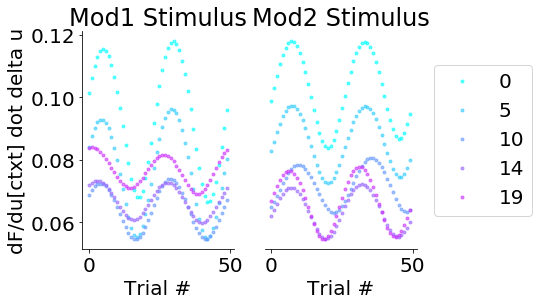

In [118]:
cmap=plt.get_cmap('cool')
cl = [.1,.9,.2,.8,.5]
n_tasks = np.shape(J_np_u_dot_delu1)[0]

# fig = plt.figure(figsize=(15, 6),tight_layout=True,facecolor='white')
for t in range(0,n_tasks):
    ax = plt.subplot(1,2,1)
    plt.plot(LA.norm(J_np_u_dot_delu1[t,:,0,:],axis = 1).T,'.',color = cmap(t/n_tasks),
             label = str(task_set[t]),linewidth = 5,alpha = .6)
#     plt.xticks(range(0,n_trials+1,int(n_trials/2)),['0',r'$\pi$',r'$2\pi$'])
    plt.xlabel('Trial #')
    plt.title('Mod1 Stimulus')
    plt.ylabel('dF/du[ctxt] dot delta u')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
#     plt.ylim((0.01,.02))

    ax = plt.subplot(1,2,2)
    plt.plot(LA.norm(J_np_u_dot_delu2[t,:,0,:],axis = 1).T,'.',label = str(task_set[t]),
             color = cmap(t/n_tasks),linewidth = 5,alpha = .6)
#     plt.xticks(range(0,n_trials+1,int(n_trials/2)),['0',r'$\pi$',r'$2\pi$'])
    plt.xlabel('Trial #')
    plt.title('Mod2 Stimulus')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
#     plt.ylim((0.01,.02))
    plt.yticks([])
    
plt.legend(loc='center left', bbox_to_anchor=[1.05,.5])
plt.savefig(fldr+'J_np_u_dot_delu1.pdf')
plt.savefig(fldr+'J_np_u_dot_delu1.png')
plt.show()

In [119]:
np.min(LA.norm(J_np_u_dot_delu1[0,:,0,:],axis = 1))

0.06655247654143549

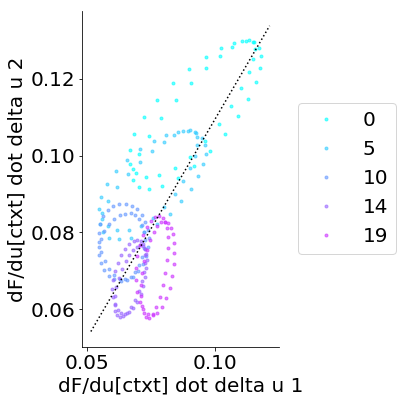

In [120]:
cmap=plt.get_cmap('cool')
cl = [.1,.9,.2,.8,.5]
n_tasks = np.shape(J_np_u_dot_delu1)[0]

fig = plt.figure(figsize=(6, 6),tight_layout=True,facecolor='white')
for t in range(0,n_tasks):
    ax = plt.subplot(1,1,1)
    plt.plot(LA.norm(J_np_u_dot_delu1[t,:,0,:],axis = 1).T,LA.norm(J_np_u_dot_delu2[t,:,0,:],axis = 1).T,
             '.',color = cmap(t/n_tasks),label = str(task_set[t]),linewidth = 5,alpha = .6)
    
    plt.xlabel('dF/du[ctxt] dot delta u 1')
    plt.ylabel('dF/du[ctxt] dot delta u 2')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
xl = ax.get_xlim()
yl = ax.get_ylim()
plt.plot([xl[0],xl[1]],[yl[0],yl[1]],':k')
# ax.axis('equal')
    
plt.legend(loc='center left', bbox_to_anchor=[1.05,.5])
plt.savefig(fldr+'J_np_u_dot_delu1.pdf')
plt.savefig(fldr+'J_np_u_dot_delu1.png')
plt.show()